In [16]:
import matplotlib.pyplot as plt
import numpy as np
import math

import qiskit
from qiskit import IBMQ, Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

from qiskit.visualization import plot_histogram
%config InlineBackend.figure_format = 'svg'

In [17]:
qreg = QuantumRegister(8)   # First 4 are for counting, last 4 for 'searching'
t = 4   # no. of counting qubits
n = 4   # no. of searching qubits
creg = ClassicalRegister(4)
circ = QuantumCircuit(qreg, creg)

In [18]:
from qiskit.aqua.circuits.gates.multi_control_toffoli_gate import _cccx

def grover_iteration():
    q = QuantumRegister(4)
    circ = QuantumCircuit(q)
    # Oracle. This has five solutions
    circ.h(3)
    _cccx(circ,q)
    circ.x(0)
    _cccx(circ,q)
    circ.x(0)
    circ.x(1)
    _cccx(circ,q)
    circ.x(1)
    circ.x(2)
    _cccx(circ,q)
    circ.x(2)
    circ.x(1)
    circ.x(2)
    _cccx(circ,q)
    circ.x(2)
    circ.x(1)
    circ.h(3)
    # Diffusion Operator
    circ.z(3)
    for qubit in q[:3]:
        circ.h(qubit)
        circ.x(qubit)
    _cccx(circ,q)
    for qubit in q[:3]:
        circ.x(qubit)
        circ.h(qubit)
    circ.z(3)
    return circ

In [19]:
# Controlled Grover block
grit = example_grover_iteration().to_gate()
cgrit = grit.control()

In [20]:
def qft(n):
    q = QuantumRegister(n)
    circ = QuantumCircuit(q)
    for j in range(n):
        circ.h(q[j])
        for k in range(j+1,n):
            circ.cu1(math.pi/float(2**(k-j)), q[k], q[j])
    for i in range(int(n/2)):
        circ.swap(q[i], q[n-i-1])
    return circ

In [21]:
qft_dagger = qft(4).to_gate().inverse()

In [22]:
# Initialise all qubits to |+> state
for qubit in qreg:
    circ.h(qubit)

In [23]:
iterations = 1
for qubit in reversed(qreg[:4]):
    for i in range(iterations):
        circ.append(cgrit, qargs=[qubit] + qreg[4:])
    iterations *= 2

In [24]:
# Inverse QFT on counting qubits
circ.append(qft_dagger, qargs=qreg[:4])

In [25]:
circ.measure(qreg[:4],creg)

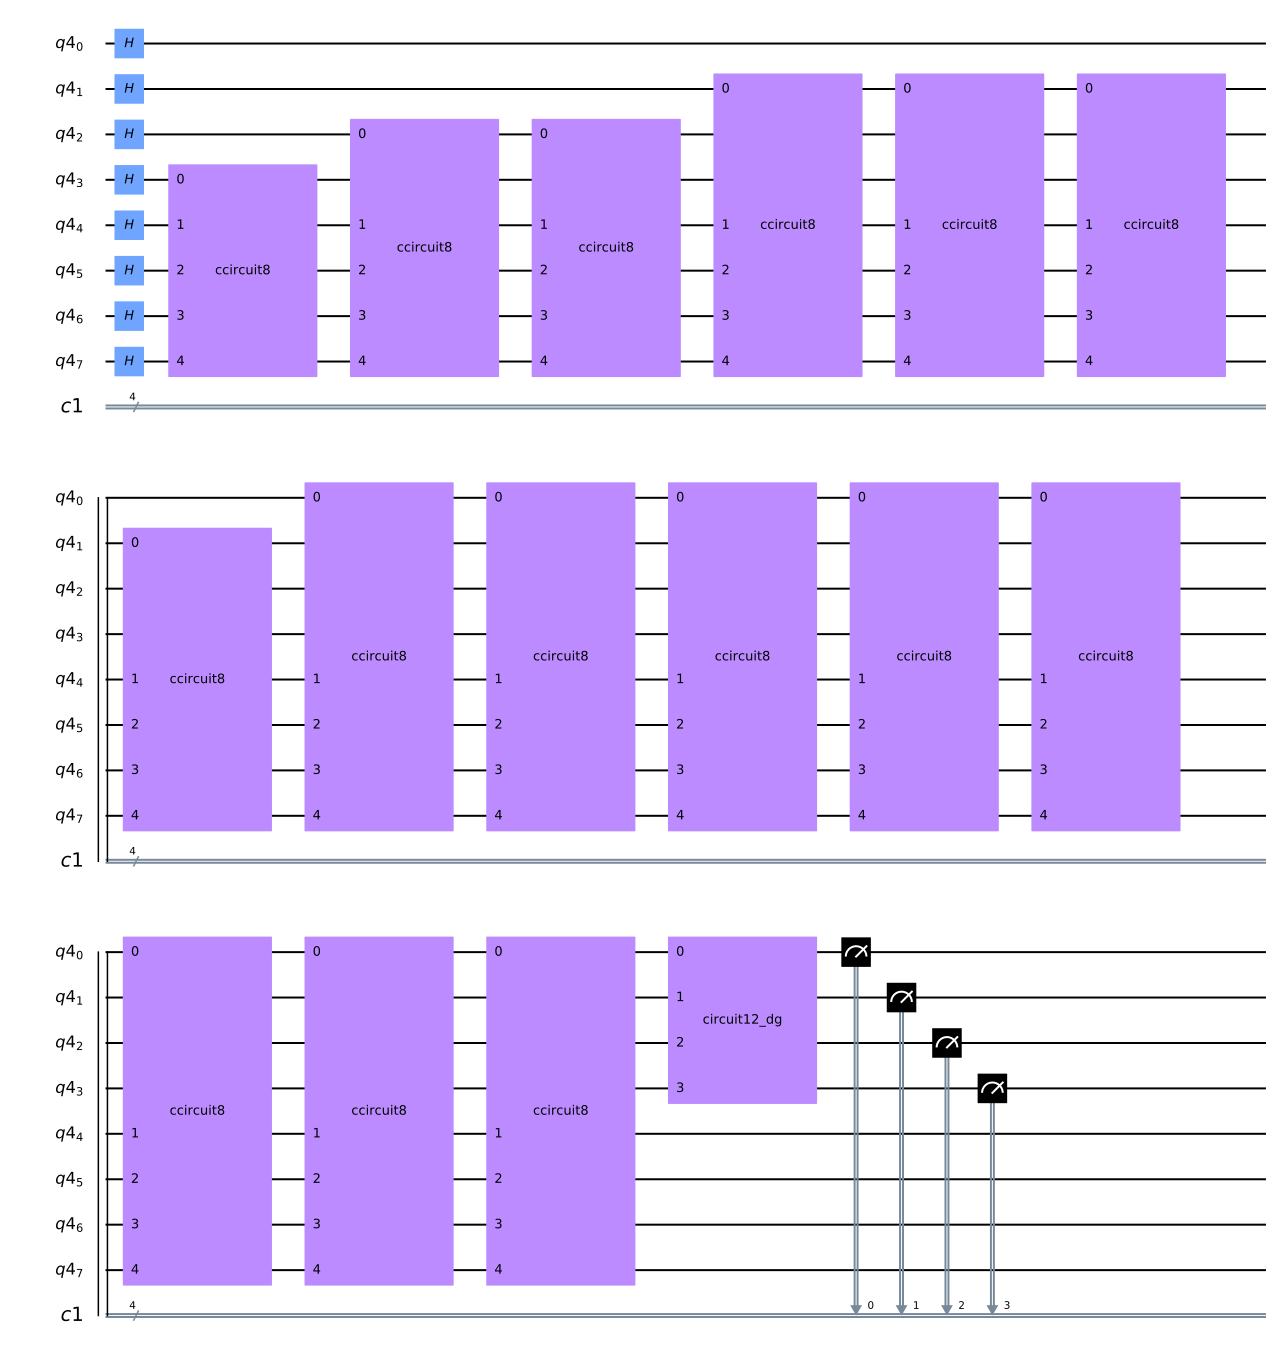

In [26]:
circ.draw(output='mpl')

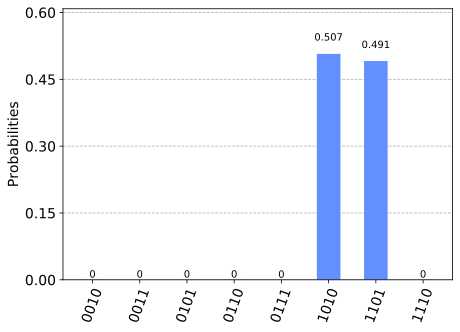

In [27]:

simulator = Aer.get_backend('qasm_simulator')
task = execute(circ, simulator, shots=8192 )
hist = task.result().get_counts()
plot_histogram(hist)

In [28]:
measured_str = max(hist, key=hist.get)
measured_str = max(hist, key=hist.get)[::-1]

In [29]:
measured_int = int(measured_str,2)
print("Register Output = %i" % measured_int)

Register Output = 5


In [30]:
theta = (measured_int/(2**t))*math.pi*2
N = 2**n
M = N * (math.sin(theta/2)**2)
print("No. of Solutions = %.1f" % (N-M))

No. of Solutions = 4.9
